This notebook will check the contents of the syseng_throughputs directories on disk, compared to main.  
Assuming you've already run the appropriate updates, this will show the difference between the current branch and main.  (this notebook uses the terminology that "main" == the github main branch, and so is the 'old' version). 

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import syseng_throughputs classes. 
import syseng_throughputs as st
from rubin_sim.phot_utils import Bandpass

In [34]:
# Set the directory of the "updated" files .. this is the same as this syseng_throughputs repository.
updatedir = os.path.normpath(os.path.join(os.getcwd(), '..'))

In [35]:
# Check out "master" (from github) into a new directory, so we can compare. 
import shutil
import subprocess

maindir = 'syseng_main'
# Remove previous copy of this directory, if it exists.
try:
    shutil.rmtree(maindir)
except OSError:
    pass
gitcommand = 'git clone https://github.com/lsst-pst/syseng_throughputs.git %s' % maindir
subprocess.run(args=gitcommand.split(), check=True)

Cloning into 'syseng_main'...


CompletedProcess(args=['git', 'clone', 'https://github.com/lsst-pst/syseng_throughputs.git', 'syseng_main'], returncode=0)

In [36]:
# Look for any differences in the component files. You can also do this at the command line with 'git status'.
# First build the lists of components (master and update) and their locations.
print("main dir: %s \nupdate dir: %s" % (maindir, updatedir))
m_componentNames = []
mainfiles = []
for root, dirs, files in os.walk(os.path.join(maindir, 'components')):
    for f in files:
        mainfiles.append(os.path.join(root, f))
        m_componentNames.append(f)
u_componentNames = []
updatefiles = []
for root, dirs, files in os.walk(os.path.join(updatedir, 'components')):
    for f in files:
        updatefiles.append(os.path.join(root, f))
        u_componentNames.append(f)

main dir: syseng_main 
update dir: /Users/lynnej/lsst_repos/syseng_throughputs


In [37]:
# Check if there are any new components.
if set(m_componentNames) == set(u_componentNames):
    print("Master and update components are the same.")
else:
    for u in u_componentNames:
        if u not in m_componentNames:
            print('New component (in updates)? %s' % u)
    for m in m_componentNames:
        if m not in u_componentNames:
            print('Deleted component (in main)? %s' % m)

New component (in updates)? m2_ProtAg.dat
New component (in updates)? m3_ProtAg.dat
New component (in updates)? m1_ProtAg.dat
New component (in updates)? L2_BBAR.dat
Deleted component (in main)? m2_ProtAg_6deg.dat
Deleted component (in main)? m3_ProtAg_6deg.dat
Deleted component (in main)? m1_ProtAg_6deg.dat
Deleted component (in main)? l2_BBAR.dat


In [38]:
# Look for any differences in the actual files. 
diff_components = []
for component in set(u_componentNames).intersection(set(m_componentNames)):
    m_idx = m_componentNames.index(component)
    u_idx = u_componentNames.index(component)
    m_comp = Bandpass()
    m_comp.read_throughput(mainfiles[m_idx])
    u_comp = Bandpass()
    u_comp.read_throughput(updatefiles[u_idx])
    try:
        if np.any(m_comp.wavelen != u_comp.wavelen):
            print('Difference in wavelength values for %s' % component)
            diff_components.append(component)
        if np.any(m_comp.sb != u_comp.sb):
            print('Difference in transmission values for %s' % component)
            diff_components.append(component)
    except ValueError:
        diff_components.append(component)

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/phot_utils/bandpass.py:82: UserWarning: Wavelength sampling of 800.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/phot_utils/bandpass.py:82: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [39]:
print(u_componentNames)
print(m_componentNames)

['m2_ProtAg.dat', 'm2_Losses.dat', 'm3_ProtAg.dat', 'm3_Losses.dat', 'm1_ProtAg.dat', 'm1_Losses.dat', 'r_band_Response.dat', 'i_band_Response.dat', 'u_band_Response.dat', 'y_band_Response.dat', 'g_band_Response.dat', 'z_band_Response.dat', 'filter_S2_Condensation.dat', 'filter_S2_Contamination.dat', 'filter_S1_Condensation.dat', 'filter_S1_Contamination.dat', 'l1_Glass.dat', 'l1_S2_Condensation.dat', 'l1_S2_Contamination.dat', 'l1_S1_Condensation.dat', 'l1_S1_Contamination.dat', 'L1_BBAR.dat', 'minDet_QE.dat', 'det_Losses.dat', 'e2v_QE.dat', 'det_Losses.dat', 'itl_QE.dat', 'det_Losses.dat', 'l2_Glass.dat', 'l2_S1_Contamination.dat', 'l2_S2_Condensation.dat', 'l2_S2_Contamination.dat', 'l2_S1_Condensation.dat', 'L2_BBAR.dat', 'l3_Glass.dat', 'l3_S2_Contamination.dat', 'l3_S2_Condensation.dat', 'l3_S1_Contamination.dat', 'l3_S1_Condensation.dat', 'L3_BBAR.dat']
['m2_ProtAg_6deg.dat', 'm2_Losses.dat', 'm3_ProtAg_6deg.dat', 'm3_Losses.dat', 'm1_ProtAg_6deg.dat', 'm1_Losses.dat', 'r_band_R

In [40]:
# Plot components with a change. 
for component in set(diff_components):
    plt.figure(figsize=(8, 5))
    m_idx = m_componentNames.index(component)
    u_idx = u_componentNames.index(component)
    m_comp = Bandpass()
    m_comp.read_throughput(mainfiles[m_idx])
    u_comp = Bandpass()
    u_comp.read_throughput(updatefiles[u_idx])
    plt.plot(m_comp.wavelen, m_comp.sb, color='red', linestyle=':', linewidth=2, label='Main')
    plt.plot(u_comp.wavelen, u_comp.sb, color='blue', linestyle='-', label='Update')
    plt.legend(loc=(0.95, 0.5), fancybox=True)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Transmission')
    plt.title('%s' % component)

In [41]:
# Plot non-matching components .. set by hand
# only relevant for the stage where we moved from Al-Ag-Al to Ag-Ag-Ag.
if 'm1_ProtAl_6deg.dat' in set(diff_components):
    for u, m in zip(['m1_ProtAg_6deg.dat', 'm2_ProtAg_6deg.dat', 'm3_ProtAg_6deg.dat'],
                    ['m1_ProtAl_6deg.dat', 'm2_ProtAg_6deg.dat', 'm3_ProtAl_6deg.dat']):
        m_idx = m_componentNames.index(m)
        u_idx = u_componentNames.index(u)
        m_comp = Bandpass()
        m_comp.read_throughput(mainfiles[m_idx])
        u_comp = Bandpass()
        u_comp.read_throughput(updatefiles[u_idx])
        plt.plot(m_comp.wavelen, m_comp.sb, linestyle=':', linewidth=2, label=f'Main {m}')
        plt.plot(u_comp.wavelen, u_comp.sb, linestyle='-', label=f'Update {u}')
    plt.legend(loc=(0.95, 0.5), fancybox=True)
    plt.xlim(200, 1200)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Transmission')

In [42]:
print('filter reference update')
for f in 'ugrizy':
    m_idx = m_componentNames.index(f'{f}_band_Response.dat')
    u_idx = u_componentNames.index(f'{f}_band_Response.dat')
    m_comp = Bandpass()
    m_comp.read_throughput(mainfiles[m_idx])
    u_comp = Bandpass()
    u_comp.read_throughput(updatefiles[u_idx])    
    print(f, m_comp.sb.max(), u_comp.sb.max())

filter reference update
u 0.86453 0.86453
g 0.97945 0.97945
r 0.97253 0.97253
i 0.98812 0.98812
z 0.9986 0.9986
y 0.99381 0.99381


In [43]:
# Now read everything and make some plots as well as compute m5 values.
# Set the default directories for the updated curves as well as the master curves. 
updateDirs = st.setDefaultDirs(rootDir=updatedir)
mainDirs = st.setDefaultDirs(rootDir=maindir)

print(updateDirs.keys())
print("Update directories (e.g.):", updateDirs['detector'])
print("Main directories (e.g.):", mainDirs['detector'])

dict_keys(['detector', 'lens1', 'lens2', 'lens3', 'filters', 'mirror1', 'mirror2', 'mirror3', 'atmosphere'])
Update directories (e.g.): /Users/lynnej/lsst_repos/syseng_throughputs/components/camera/detector/joint_minimum
Main directories (e.g.): syseng_main/components/camera/detector/joint_minimum


In [44]:
# Read the combined default components. (note this uses the joint_minimum detector)
# Hardware = telescope + camera only. System = also with atmosphere.
update_hardware, update_system = st.buildHardwareAndSystem(updateDirs, addLosses=True)
main_hardware, main_system = st.buildHardwareAndSystem(mainDirs, addLosses=True)

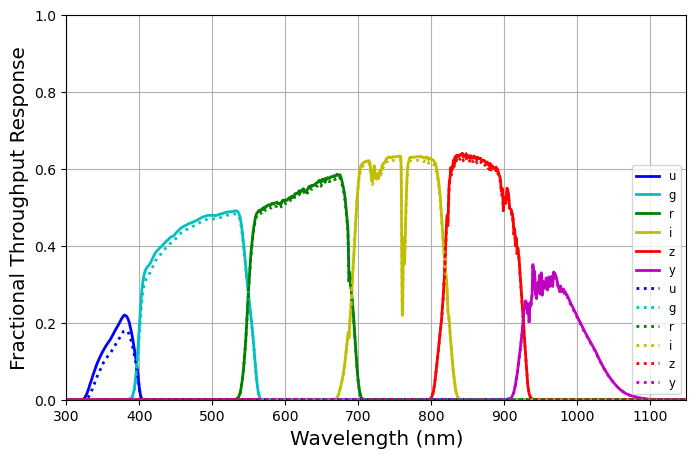

In [45]:
# Plot all of the components: everything
plt.figure(figsize=(8, 5))
st.plotBandpasses(update_system, newfig=False, addlegend=False)
st.plotBandpasses(main_system, linestyle=':', newfig=False, addlegend=True)

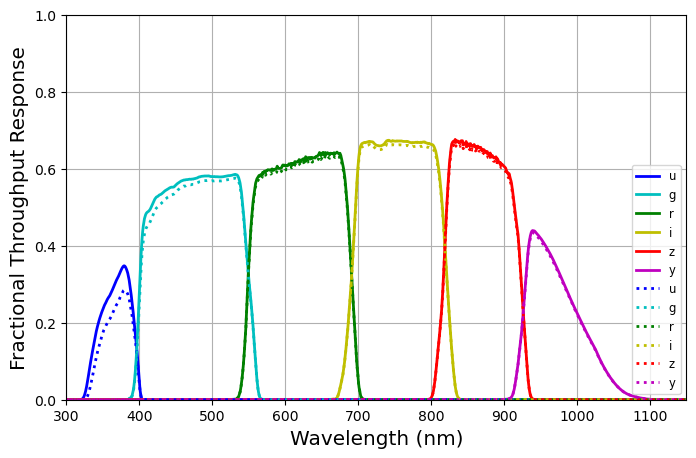

In [46]:
# Plot all of the components. Just the hardware
plt.figure(figsize=(8, 5))
st.plotBandpasses(update_hardware, newfig=False, addlegend=False)
st.plotBandpasses(main_hardware, linestyle=':', newfig=False, addlegend=True)

In [47]:
# Compare m5 values before/after the update.
update_m5 = st.makeM5(update_hardware, update_system, darksky=None, 
                     readnoise=8.8, othernoise=0, darkcurrent=0.2,
                      effarea=np.pi*(6.423/2*100)**2, X=1.0, fwhm500=0.72)
main_m5 = st.makeM5(main_hardware, main_system, darksky=None, 
                    readnoise=8.8, othernoise=0, darkcurrent=0.2,
                      effarea=np.pi*(6.423/2*100)**2, X=1.0, fwhm500=0.72)

In [48]:
update_m5

,nexp,exptime,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,1.0,30.0,1.039050,0.906099,23.017613,61.645806,26.714849,0.027328,0.046605,0.579570,0.037932,23.116333,0.449270,0.275724,23.696293,483.663701,23.9,23.4
g,2.0,15.0,0.978073,0.855976,22.258617,477.755650,28.502071,0.141740,0.179529,0.256607,0.038939,24.492739,0.155281,0.081523,24.758864,942.765786,25.0,24.6
r,2.0,15.0,0.922016,0.809897,21.197526,1003.549292,28.352270,0.123473,0.141916,0.151149,0.039164,24.550537,0.079833,0.039400,24.350199,1196.602453,24.7,24.3
i,2.0,15.0,0.883147,0.777947,20.462546,1612.299022,28.171838,0.104568,0.115864,0.111369,0.039292,24.511060,0.051161,0.024234,23.989996,1412.076115,24.0,23.6
z,2.0,15.0,0.857254,0.756663,19.606379,2417.688202,27.786357,0.073317,0.078965,0.080569,0.039394,24.351793,0.034702,0.015812,23.434954,1650.754810,23.3,22.9
y,2.0,15.0,0.836460,0.739570,18.601615,2756.911328,26.811261,0.029865,0.035690,0.193458,0.039416,23.812287,0.030560,0.013696,22.419727,1712.911312,22.1,21.7


In [49]:
main_m5

,nexp,exptime,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,1.0,30.0,1.039050,0.906099,23.051983,45.303229,26.431136,0.021044,0.035351,0.563217,0.037809,22.878537,0.546032,0.347099,23.475682,456.354840,23.9,23.4
g,2.0,15.0,0.978073,0.855976,22.253839,463.634122,28.466167,0.137129,0.173458,0.255157,0.038928,24.471199,0.159339,0.083862,24.734935,932.425140,25.0,24.6
r,2.0,15.0,0.922016,0.809897,21.197579,988.626863,28.336068,0.121644,0.139813,0.151139,0.039159,24.541236,0.080946,0.039994,24.340924,1188.991566,24.7,24.3
i,2.0,15.0,0.883147,0.777947,20.462795,1588.280513,28.155805,0.103035,0.114164,0.111356,0.039287,24.502239,0.051896,0.024611,23.981300,1402.565613,24.0,23.6
z,2.0,15.0,0.857254,0.756663,19.606305,2381.945498,27.770116,0.072229,0.077792,0.080565,0.039390,24.343109,0.035204,0.016063,23.426233,1639.361557,23.3,22.9
y,2.0,15.0,0.836460,0.739570,18.601512,2717.111941,26.795413,0.029433,0.035172,0.193414,0.039412,23.803892,0.030993,0.013910,22.411280,1701.275111,22.1,21.7


In [50]:
print("Resulting changes in m5 (positive = fainter)")
pd.DataFrame((update_m5.m5 - main_m5.m5).values, index=update_m5.index, columns=['Delta m5'])

Resulting changes in m5 (positive = fainter)


,Delta m5
u,0.220611
g,0.023929
r,0.009275
i,0.008696
z,0.008721
y,0.008447


In [51]:
# When all done - remove the git clone.
shutil.rmtree(maindir)